# Лабораторная работа №2.

Выполнил: студент гр. 9383 Моисейченко Кирилл.

## Цель работы:

Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.

## Задание:

1. Средствами ОС Windows записать свой речевой сигнал. Фраза — "Добрый день, я учусь в университете ЛЭТИ, на факультете компьютерных
технологий и информатики". Формат записи— моно-сигнал, 16000 гц или 22000 гц, без сжатия (wav-формат).

2. Используя ДПФ построить траекторию основного тона (${F0}$) на записи своего голоса.
3. Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на
записи своего голоса
4. Построить сонограмму по записи своего голоса.

Замечание:
* Все пункты лабораторной работы выполняем анализом спектра, без использования методов библиотек Librosa и OpenSMILE.
полученных результатов.

## Выполнение работы:

### 1. Запись и загрузка аудио сигнала.

Был записан речевой моно-сигнал с частотой дискретизации 16000 гц в wav-формате.

In [1]:
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import more_itertools as mit

In [2]:
sound_rate, sound = wavfile.read('voice.wav')

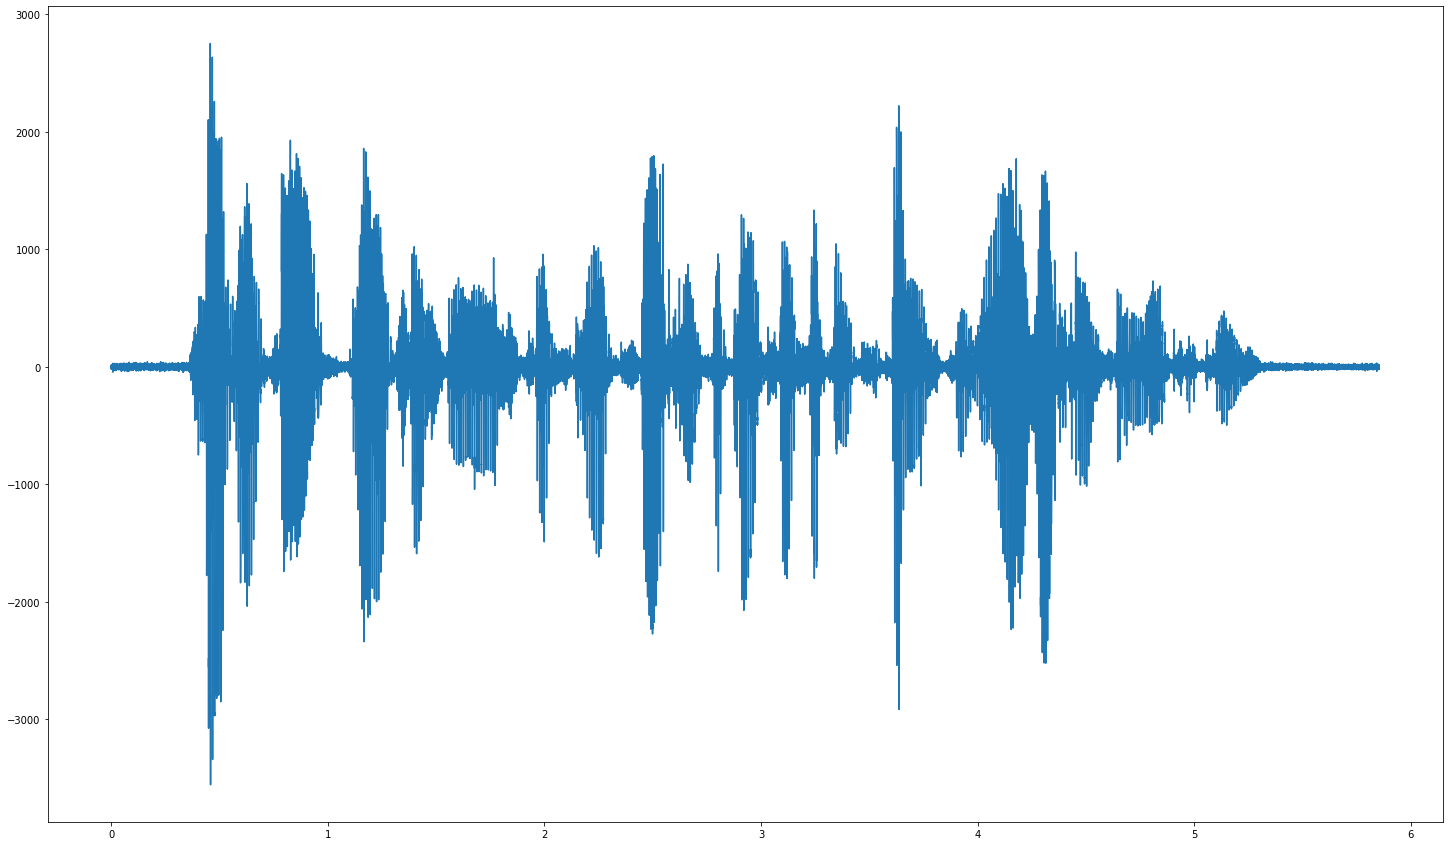

In [3]:
sound_time = sound.size / sound_rate
x = np.linspace(0, sound_time, sound.size)

plt.rcParams["figure.figsize"]=25, 15
plt.plot(x, sound)

### 2. Построение траектории основного тона (F0) используя ДПФ.

Частотой основного тона (${F0}$) называют частоту вибрации голосовых связок. У каждого
говорящего базовая частота основного тона индивидуальна и обусловлена особенностями
строения гортани. Частота основного тона различна для мужских (примерный диапазон:
80− 200 Hz) и женских (примерный диапазон: 160− 350 Hz) голосов.

#### Алгоритм построения ${F0}$:
1. Разбиваем сигнал на отрезки длиной $N$ . Рекомендуется работа с перекрытиями: сдвиг
для следующего интервала ${0.5N}$, ${0.25N}$.
2. На каждом отрезке сигнал предварительно умножаем на окно (Хеннига (Ханна),
Хемминга, Блекмана-Харриса, Кайзера-Бесселя и т.п.), затем вычисляем
ДПФ и на его основе амплитудный спектр в интервале ${(0,N/2)}$.
3. Ищем существенное максимальное значение амплитудного спектра на отрезке ${[n_l,n_u]}$ —
это будет частота основного тона ${F0}$ (точка амплитудного спектра ${n_0}$). Если такого
максимума нет — это интервал паузы или не вокализованного звука. Полагаем ${F0 = 0}$.

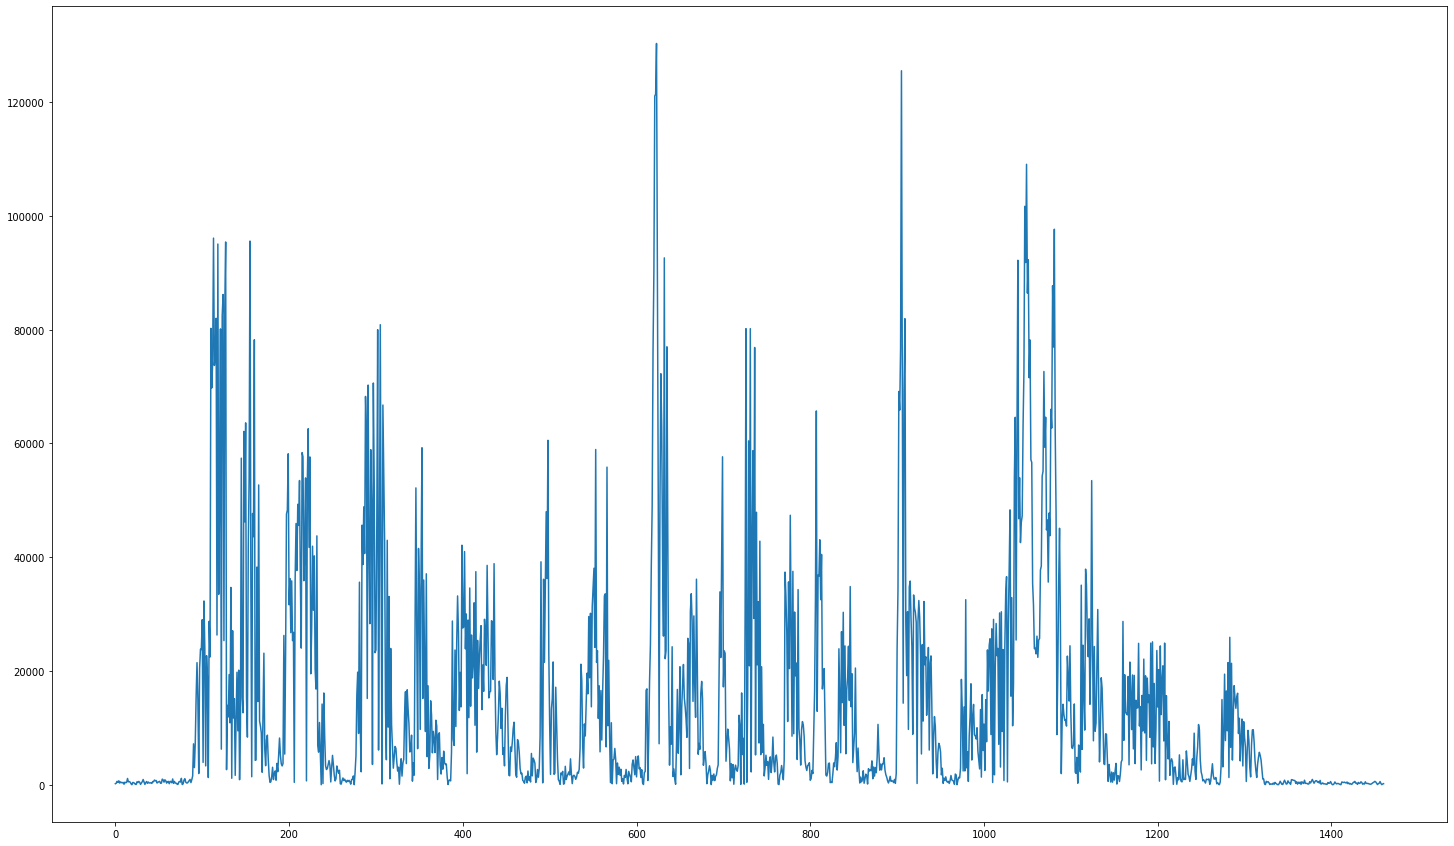

In [4]:
N = 256
intervals = list(mit.windowed(sound ,n=N , step=int(0.25*N)))
intervals[-1] = [i for i in intervals[-1] if i]
intervals = [i*np.hamming(len(i)) for i in intervals]

def DFT(x):
    n = np.arange(len(x), dtype=float)
    k = n.reshape(len(x), 1)
    e = np.exp(-2j*np.pi*k*n/N)
    return (np.dot(e, x))

dft_intervals = [DFT(i) for i in intervals]
amp_spectr = [(sum([j**2 for j in i[:int(len(i)/2)]])**0.5).real for i in dft_intervals]
f = []
for i in range(0, len(amp_spectr), int(sound_rate/N)):
    f.append(np.array(amp_spectr[i:i + int(sound_rate/N)]))

F0 = []
for i in f:
    if i.max() > 2*i.mean():
        F0 += (i.tolist())
    else:
        F0 += np.zeros(len(i)).tolist()

plt.plot(F0)

### 3. Построение траектории второй, третьей и четвертой формантных частот используя ДПФ.

Акустические резонансы в голосовом тракте создают пики в огибающей спектра звука. Такие
пики называются формантами. Частота основного тона является первой формантой, далее
идут вторая, третья и четвертая форматны: F1, F2, F3. Амплитуда каждой последующей
форманты ниже, чем предыдущей, а их частоты примерно равны частоте основного тона
умноженного на целое число:

$F1 ≈ 2F0, F2 ≈ 3F0, F3 ≈ 4F0$

#### Алгоритм построения ${F1, F2, F3}$:
4. В окрестности точки ${2n0}$ ищем максимальное значение амплитудного спектра, которое
должно быть существенно меньше значения в точке ${n_0}$. Если это предположение верно,
то мы нашли частоту второй форманты ${F1}$. Если нет — второй форманты у сигнала на
этом отрезке нет. Полагаем ${F1 = 0}$
5. Далее проводим поиск для третьей форманты в окрестности точки ${3n_0}$. Повторяем
процесс для четвертой форманты в окрестности точки ${4n_0}$.

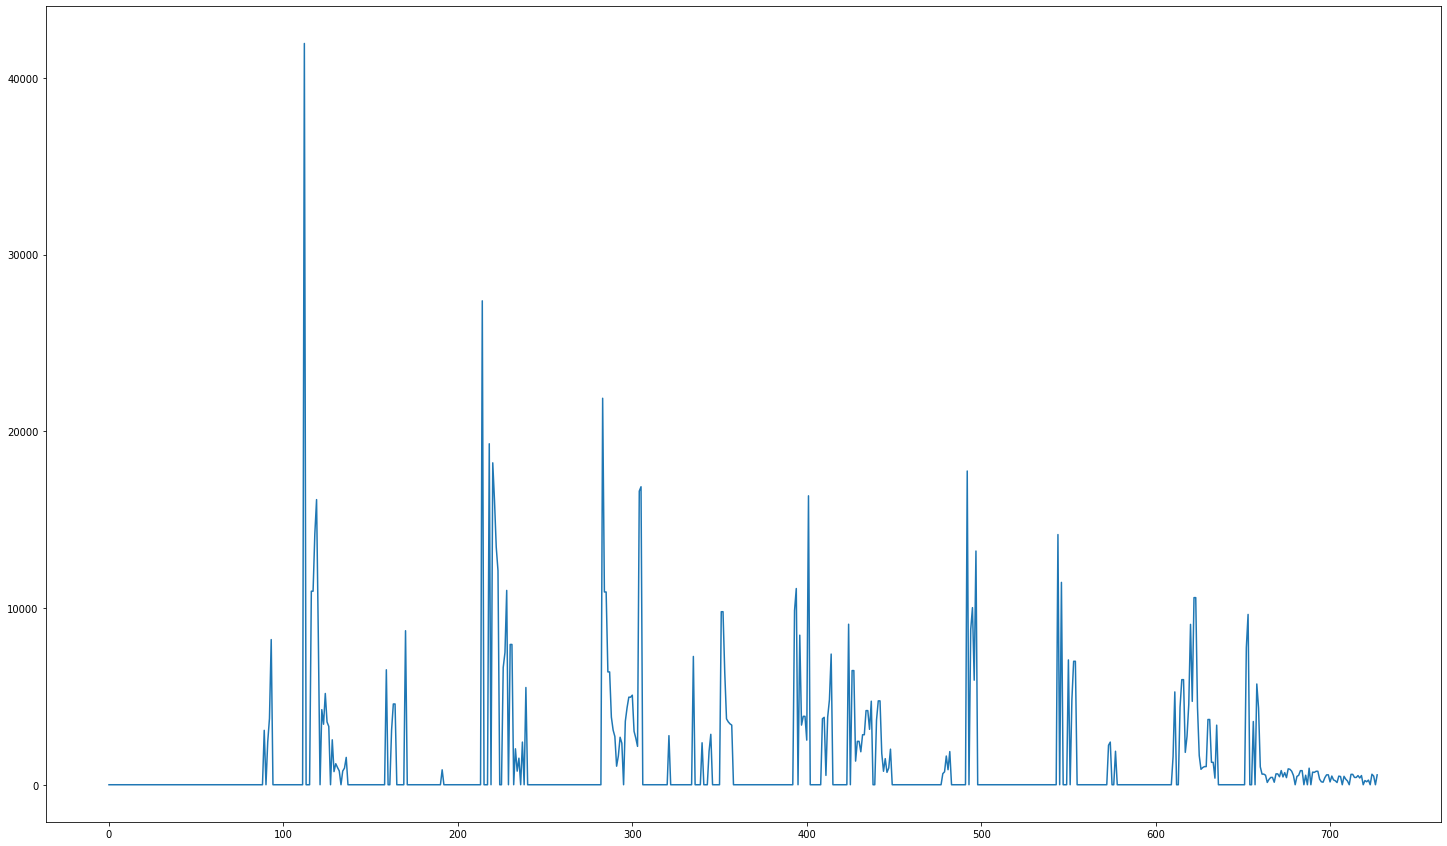

In [5]:
F1 = []
i = 1
while i < round(len(F0)/2)-1:
    max_ = max([F0[2*i-1], F0[2*i], F0[2*i+1]])
    if F0[i] > 2*max_:
        F1 += [max_]
    else:
        F1 += [0]
    i += 1

plt.plot(F1)

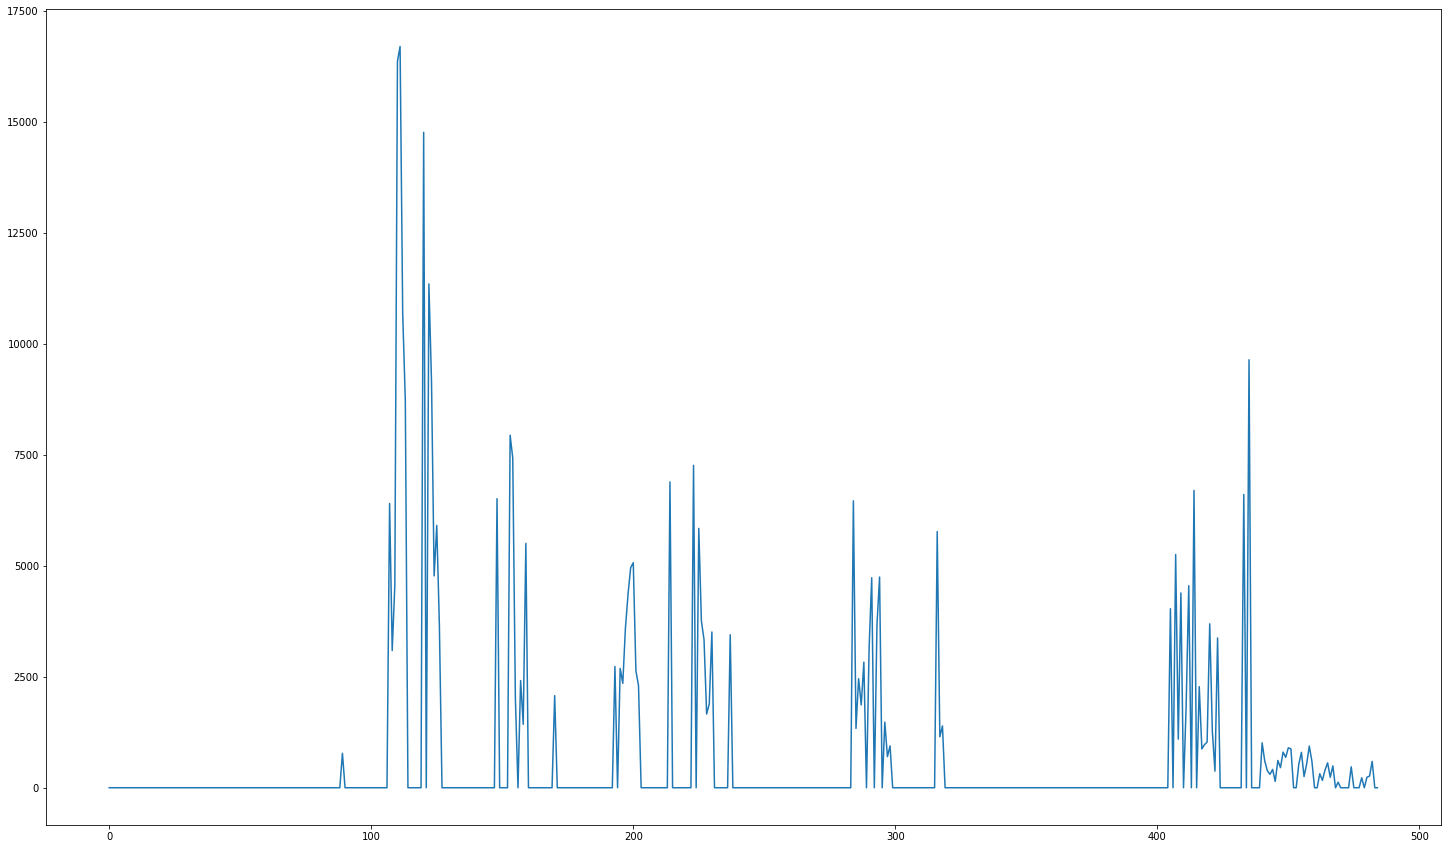

In [6]:
F2 = []
i = 1
while i < round(len(F0)/3)-1:
    max_ = max([F0[3*i-1], F0[3*i], F0[3*i+1]])
    if F0[i] > 4*max_:
        F2 += [max_]
    else:
        F2 += [0]
    i += 1

plt.plot(F2)

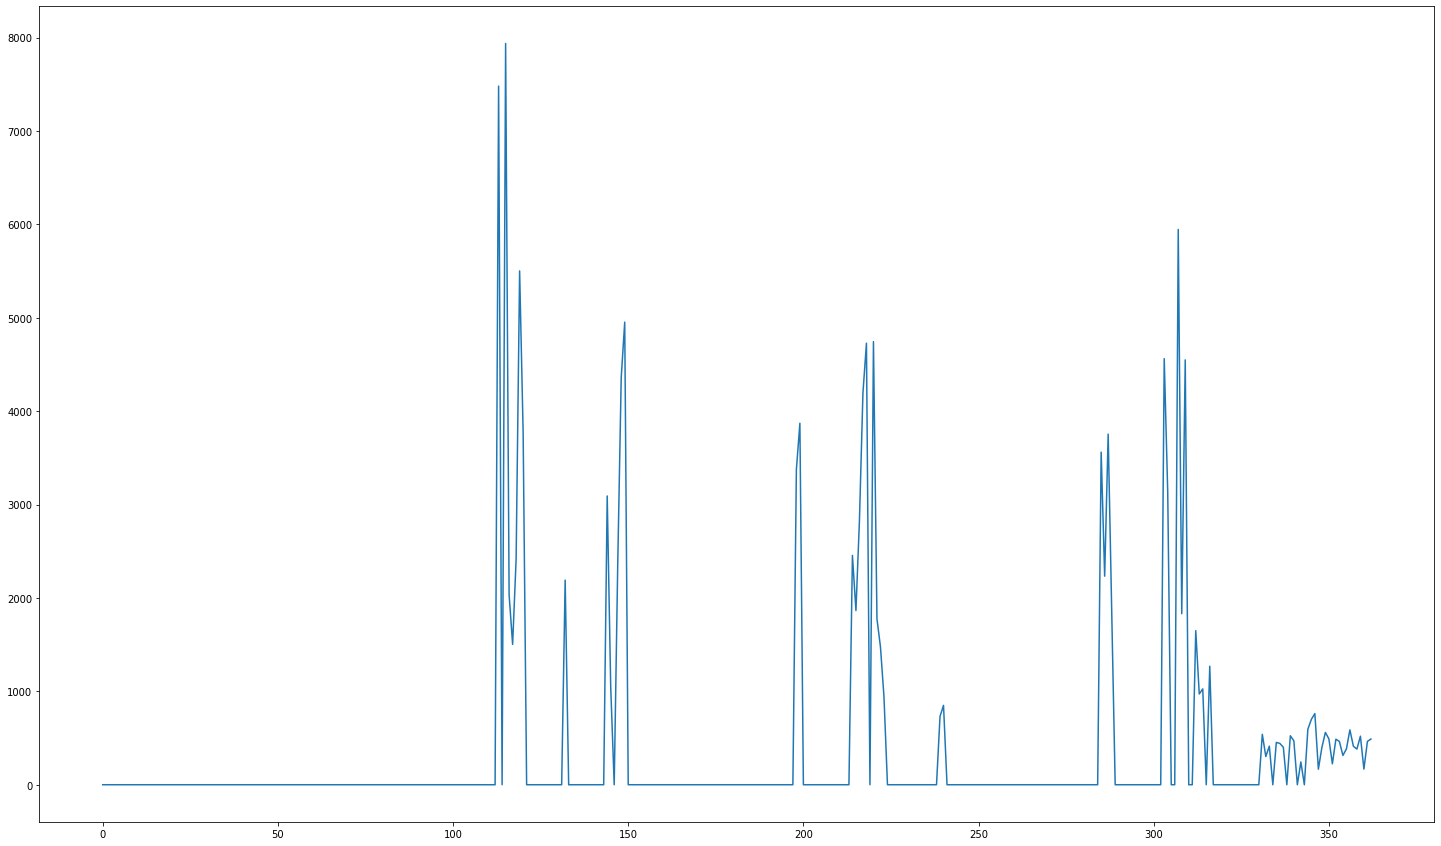

In [7]:
F3 = []
i = 1
while i < round(len(F0)/4)-1:
    max_ = max([F0[4*i-1], F0[4*i], F0[4*i+1]])
    if F0[i] > 8*max_:
        F3 += [max_]
    else:
        F3 += [0]
    i += 1
    
plt.plot(F3)

### 4. Построение сонограммы по записи голоса.

Сонограма — это изображение кратковременного спектра сигнала (спектров на
последовательности кадров) в координатах времени (горизонтальная ось), частоты
(вертикальная ось) и энергии голоса (степень зачернения, цвет).
Интенсивность темного (или цвета) отображает амплитуду спектра. Наиболее темные
горизонтальные полосы частот показывают спектральные максимумы.

#### Алгоритм построения сонограммы:
1. Повторяем первые три шага алгоритма вычисления ${F0}$.
2. Находим максимальное значение амплитудного спектра для ${F0}$ по всему сигналу —
${A_{Max}}$.
3. Интенсивность темного (или цвета) определяем относительно значения ${A_{Max}}$.
4. Интенсивность столбца значений амплитудного спектра выводим в интервале
50− 4000 Hz.
5. Размерность столбца определяется пользователем.

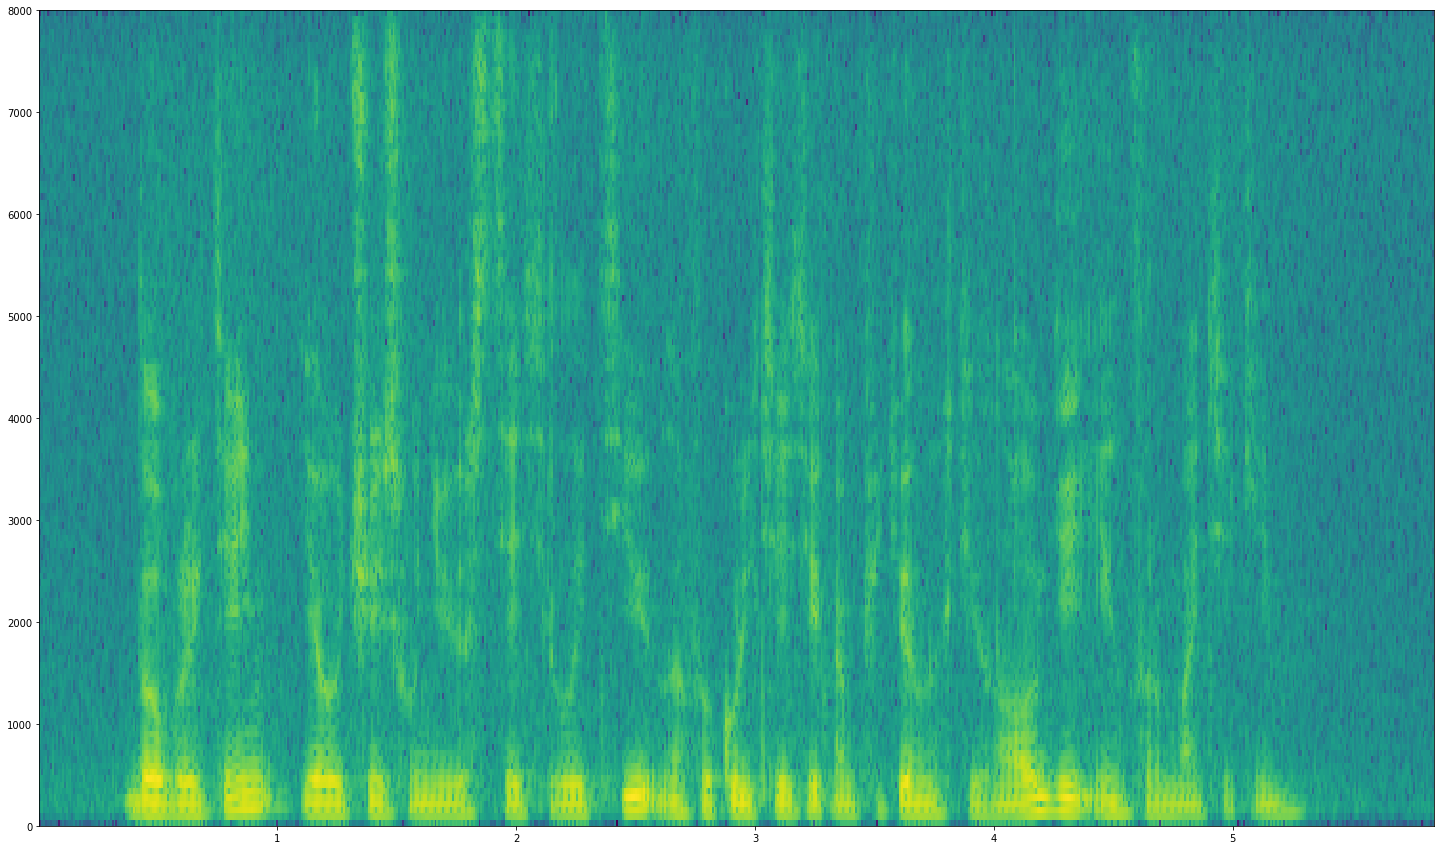

In [8]:
plt.specgram(sound,NFFT=N, pad_to=N, Fs=sound_rate)
plt.show()